# Challenge: Build your own NLP Model

Will be predicting Sentiment on Tweets. Will be using a dataset from Sentiment140 which contains 1.6 million labeled tweets.

1. 0 — the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
2. 1 — the id of the tweet (2087)
3. 2 — the date of the tweet (Sat May 16 23:58:44 UTC 2009)
4. 3 — the query (lyx). If there is no query, then this value is NO_QUERY.
5. 4 — the user that tweeted (robotickilldozr)
6. 5 — the text of the tweet (Lyx is cool)

In [19]:
############# Imports ####################
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
import spacy
spacy.load('en')
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import Normalizer

import re
import time
from nltk.corpus import gutenberg, stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import chi2, f_classif
from sklearn.feature_selection import SelectKBest
import boto3
import io
from sklearn.metrics import classification_report

####### Models ########
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model

import warnings
warnings.filterwarnings('ignore')

In [2]:
#################################### Bring in Data #############################################
start_time = time.time()
s3 = boto3.client('s3')

#Bring in Training Data
obj = s3.get_object(Bucket='data-science-project-data', Key='Twitter_Sentiment_Analysis/training.1600000.processed.noemoticon.csv')
cols = ['sentiment','id','date','query_string','user','text']
tweets = pd.read_csv(io.BytesIO(obj['Body'].read()),header=None, names=cols, encoding = "ISO-8859-1")
#train.set_index('bidder_id', inplace=True)

print("-- Execution time: %s seconds ---" % (time.time() - start_time))

-- Execution time: 6.674104928970337 seconds ---


In [3]:
tweets.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
#Very Well Balanced
tweets['sentiment'].value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

-- Execution time: 4.775571584701538 seconds ---


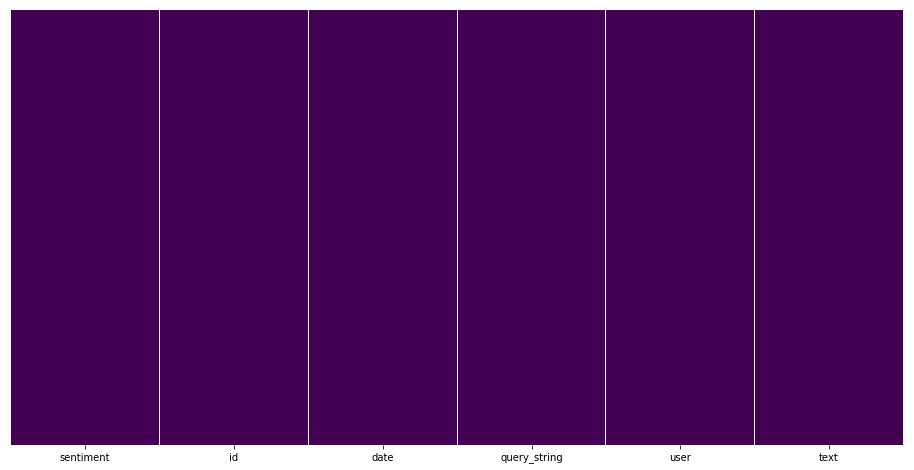

In [11]:
# Is there any missing data? - No
plt.figure(figsize=(16,8))
start_time = time.time()
sns.heatmap(tweets.isnull(), yticklabels=False, cbar=False, cmap='viridis')
print("-- Execution time: %s seconds ---" % (time.time() - start_time))

In [6]:
# Just Need the Sentiment and the Text
tweets.drop(['id','date','query_string','user'],axis=1,inplace=True)

In [5]:
tweets.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [3]:
def clean_tweet(tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [4]:
# Clean the tweets, by removing special characters
start_time = time.time()
tweets['Clean'] = tweets['text'].apply(lambda x: clean_tweet(x))
print("-- Execution time: %s seconds ---" % (time.time() - start_time))

-- Execution time: 16.67865300178528 seconds ---


In [7]:
tweets.head()

,sentiment,text,Clean
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Awww that s a bummer You shoulda got David Car...
1,0,is upset that he can't update his Facebook by ...,is upset that he can t update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball Managed to sav...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",no it s not behaving at all i m mad why am i h...


In [8]:
tweets['Clean'].head(10)

0    Awww that s a bummer You shoulda got David Car...
1    is upset that he can t update his Facebook by ...
2    I dived many times for the ball Managed to sav...
3       my whole body feels itchy and like its on fire
4    no it s not behaving at all i m mad why am i h...
5                                   not the whole crew
6                                           Need a hug
7    hey long time no see Yes Rains a bit only a bi...
8                           K nope they didn t have it
9                                         que me muera
Name: Clean, dtype: object

In [9]:
#Down Sample The data to evaluate only a small portion to speed up the time it takes to evaluate different models. 
# Once the highest performing model is found, then can train on the fuller dataset. and Create pipeline for the final model.
tweets_subsampled_1, tweets_subsampled_2 = train_test_split(tweets, test_size=0.1)

In [10]:
len(tweets_subsampled_2)

160000

In [11]:
tweets_subsampled_2['sentiment'].value_counts()

4    80122
0    79878
Name: sentiment, dtype: int64

In [12]:
#Split between outcome and Features
y = tweets_subsampled_2['sentiment']
X = tweets_subsampled_2['Clean']

In [13]:
# Vectorize the Clean tweets. This also invovled using the lemmatizer from Spacy.
start_time = time.time()
# Create lemmatizer using spacy
lemmatizer = spacy.lang.en.English()

def custom_tokenizer(doc):
    tokens = lemmatizer(doc)
    return([token.lemma_ for token in tokens])

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True, #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            ngram_range=(1,2), # Add 2 word phrases
                             tokenizer=custom_tokenizer
                            )


#Applying the vectorizer
tweets_tfidf=vectorizer.fit_transform(X)
print("-- Execution time: %s seconds ---" % (time.time() - start_time))
print("Number of features: %d" % tweets_tfidf.get_shape()[1])



-- Execution time: 23.724626302719116 seconds ---
Number of features: 110743


In [14]:
#Our SVD data reducer.  We are going to reduce the feature space to 2000.
start_time = time.time()
svd= TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the tweets data, then project the training data.
tweets_lsa = lsa.fit_transform(tweets_tfidf)
print("-- Execution time: %s seconds ---" % (time.time() - start_time))

-- Execution time: 11.66292929649353 seconds ---


In [15]:
#splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(tweets_lsa,y,test_size=0.3)

### Model Training

Will need to take a subset of the data to try different models on, and then train on the full set. Will try several models:

1. Logistic Regression (Ridge and Lasso)
2. Stoachastic Gradient Descent (SGD with Hinge - SVM)
3. Gradient Boosted Tree (Will take considerably long time)
4. Random Forest. (Will take a long time)

In [16]:
################ Logistic Regression ######################
start_time = time.time()
parameters = {
                'penalty':['l1'],
                'C':[1],
                'class_weight':['balanced']
               
              }

lr = LogisticRegression()

grid = GridSearchCV(lr, parameters, scoring='accuracy', cv=3, verbose=0)
#Fit the Data
grid.fit(X_train, y_train)
print(grid.score(X_test, y_test))
print("-- Execution time: %s seconds ---" % (time.time() - start_time))

0.7057083333333334
-- Execution time: 10.045667171478271 seconds ---


In [16]:
grid.best_params_

{'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'}

In [17]:
log_prediction = grid.predict(X_test)
print(classification_report(y_test, log_prediction))

             precision    recall  f1-score   support

          0       0.72      0.67      0.69     23884
          4       0.69      0.74      0.72     24116

avg / total       0.71      0.71      0.71     48000



In [24]:
###################### SGD #############################
start_time = time.time()
parameters = {
                'loss':['log'],
                'penalty':['l2'],
                'fit_intercept':[True],
                'class_weight':['balanced']
               
              }

clf = linear_model.SGDClassifier(n_jobs=-1)

grid = GridSearchCV(clf, parameters, scoring='accuracy', cv=5, verbose=0)
#Fit the Data
grid.fit(X_train, y_train)
print(grid.score(X_test, y_test))
print("-- Execution time: %s seconds ---" % (time.time() - start_time))

0.7497083333333333
-- Execution time: 48.20784306526184 seconds ---


In [33]:
grid.best_params_

{'class_weight': 'balanced',
 'fit_intercept': True,
 'loss': 'log',
 'penalty': 'l2'}

In [25]:
sgd_prediction = grid.predict(X_test)
print(classification_report(y_test, sgd_prediction))

             precision    recall  f1-score   support

          0       0.77      0.72      0.74     48271
          4       0.73      0.78      0.76     47729

avg / total       0.75      0.75      0.75     96000



In [20]:
################ Gradient Boost #############################
start_time = time.time()
parameters = {'subsample':[1],
              'max_depth':[2],
              'loss':['exponential'],
             'n_estimators':[500]}

# Initialize the model.
clf = GradientBoostingClassifier()

#Create grid and perform 5 cross validation
gradient_grid = GridSearchCV(clf, parameters, cv=3, verbose=0)

#Fit the Data
gradient_grid.fit(X_train, y_train)
print(gradient_grid.score(X_test, y_test))
print("--- %s seconds ---" % (time.time() - start_time))

0.7023125
--- 838.5373966693878 seconds ---


In [21]:
gb_prediction = grid.predict(X_test)
print(classification_report(y_test, gb_prediction))

             precision    recall  f1-score   support

          0       0.72      0.67      0.69     23884
          4       0.69      0.74      0.72     24116

avg / total       0.71      0.71      0.71     48000



In [ ]:
################ Random Forest #############################
start_time = time.time()
parameters = {
               'n_estimators':[10,100,200],
                'criterion':['gini','entropy'],
                'max_depth':[None, 2, 4, 6],
                'class_weight':[None, 'balanced'],
               'max_features': ['auto']
              }
rfc = RandomForestClassifier(n_jobs=-1)

random_forest_grid = GridSearchCV(rfc, parameters, scoring='accuracy', cv=3, verbose=0)
#Fit the Data
random_forest_grid.fit(X_train, y_train)
print(random_forest_grid.score(X_test, y_test))
print("--- %s seconds ---" % (time.time() - start_time))

In [24]:
rf_prediction = grid.predict(X_test)
print(classification_report(y_test, rf_prediction))

             precision    recall  f1-score   support

          0       0.73      0.65      0.69     47970
          4       0.69      0.76      0.72     48030

avg / total       0.71      0.71      0.71     96000



SGD proved to be the fastest and accurate model. Will now try to just act on the features.

In [19]:
#splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(tweets_tfidf,y,test_size=0.3)

In [20]:
################ SGD ######################
start_time = time.time()
parameters = {
                'loss':['log'],
                'penalty':['l2'],
                'fit_intercept':[True],
                'class_weight':['balanced']
               
              }

clf = linear_model.SGDClassifier(n_jobs=-1)

grid = GridSearchCV(clf, parameters, scoring='accuracy', cv=5, verbose=0)
#Fit the Data
grid.fit(X_train, y_train)
print(grid.score(X_test, y_test))
print("-- Execution time: %s seconds ---" % (time.time() - start_time))

0.7485208333333333
-- Execution time: 2.2076778411865234 seconds ---


In [21]:
sgd_prediction = grid.predict(X_test)
print(classification_report(y_test, sgd_prediction))

             precision    recall  f1-score   support

          0       0.77      0.71      0.74     48200
          4       0.73      0.78      0.76     47800

avg / total       0.75      0.75      0.75     96000



## Pipelining

Since Im going to pick the SGD model, will streamline this process. I have already done a grid search to find the optmimal parameters for the different models, now I need to find the optimal settings for the vectorization. 

In [27]:
#splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [39]:
start_time = time.time()
# Create lemmatizer using spacy
lemmatizer = spacy.lang.en.English()

def custom_tokenizer(doc):
    tokens = lemmatizer(doc)
    return([token.lemma_ for token in tokens])

pipe = Pipeline(steps=[('vectidf', TfidfVectorizer(tokenizer=custom_tokenizer, stop_words='english',lowercase=True,use_idf=True,max_df=0.5)),
                 ('svd', TruncatedSVD(500)),
                 ('norm',Normalizer(copy=False)),
                 ('sgd',linear_model.SGDClassifier(loss='log',penalty='l2',fit_intercept=True, class_weight='balanced', n_jobs=50))
                 ])

parameters = {'vectidf__ngram_range': [(1, 1), (1, 2)],
              'vectidf__min_df':(1,2),
              'vectidf__norm':['l1','l2'],
              'vectidf__smooth_idf':[True, False]    
}

grid = GridSearchCV(pipe, parameters, n_jobs=50, cv=5, verbose=0)
grid.fit(X_train, y_train)

print("-- Execution time: %s seconds ---" % (time.time() - start_time))

-- Execution time: 2130.344949245453 seconds ---


In [40]:
grid.best_score_

0.7362875

In [42]:
grid.best_params_

{'vectidf__min_df': 2,
 'vectidf__ngram_range': (1, 2),
 'vectidf__norm': 'l2',
 'vectidf__smooth_idf': False}

In [41]:
start_time = time.time()
print(grid.score(X_test, y_test))
print("-- Execution time: %s seconds ---" % (time.time() - start_time))

0.7387
-- Execution time: 12.548697471618652 seconds ---
